# Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor

# Load Data

In [2]:
data = pd.read_csv("../../data/processed/extended_features/training_numeric_cleaned_extra_features_winsorization.csv", sep="\t")
X = data.drop(columns=["ActualTOW"])
y = data["ActualTOW"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PreProcessing data

In [3]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

# Load Models

In [4]:
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
xgb = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2, random_state=42)

# Equal weight Voting
voting_eq = VotingRegressor(estimators=[
    ("lr", lr),
    ("rf", rf),
    ("xgb", xgb)
])

# Weighted Voting
voting_weighted = VotingRegressor(estimators=[
    ("lr", lr),
    ("rf", rf),
    ("xgb", xgb)
], weights=[1, 2, 3])  # większa waga dla najlepszego modelu

# Stacking
stacking = StackingRegressor(
    estimators=[("lr", lr), ("rf", rf), ("xgb", xgb)],
    final_estimator=LinearRegression(),
    cv=5
)

models = {
    "Voting Equal": voting_eq,
    "Voting Weighted": voting_weighted,
    "Stacking": stacking
}

# Training

In [5]:
results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{name} => RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae
    })

Voting Equal => RMSE: 728.26, MAE: 529.30
Voting Weighted => RMSE: 760.69, MAE: 555.71
Stacking => RMSE: 703.86, MAE: 508.25


# Results

C:\Users\huber\AppData\Local\Temp\ipykernel_31100\3127668923.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="RMSE", palette="Set2")


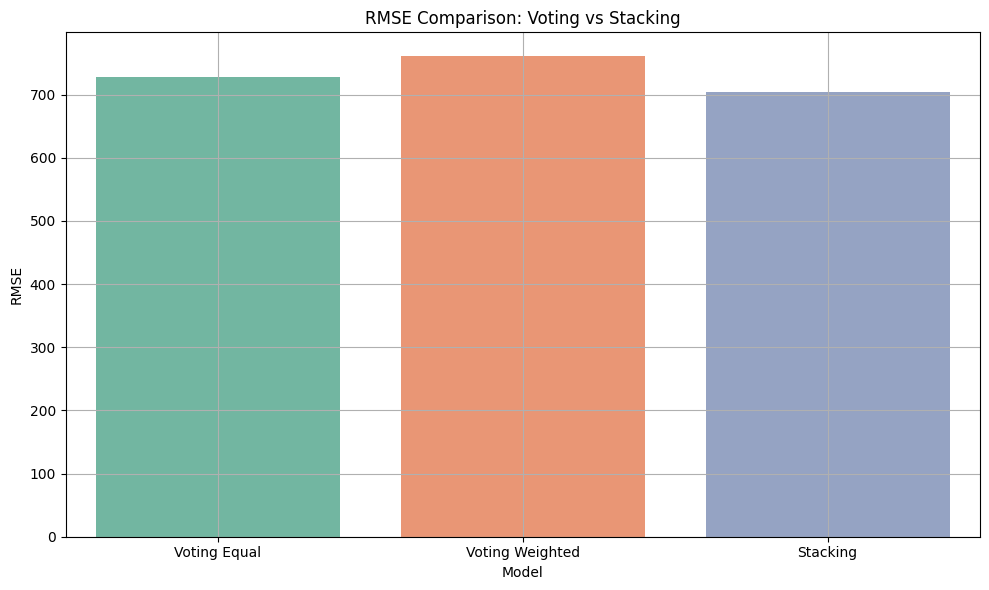

C:\Users\huber\AppData\Local\Temp\ipykernel_31100\3127668923.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="MAE", palette="Set3")


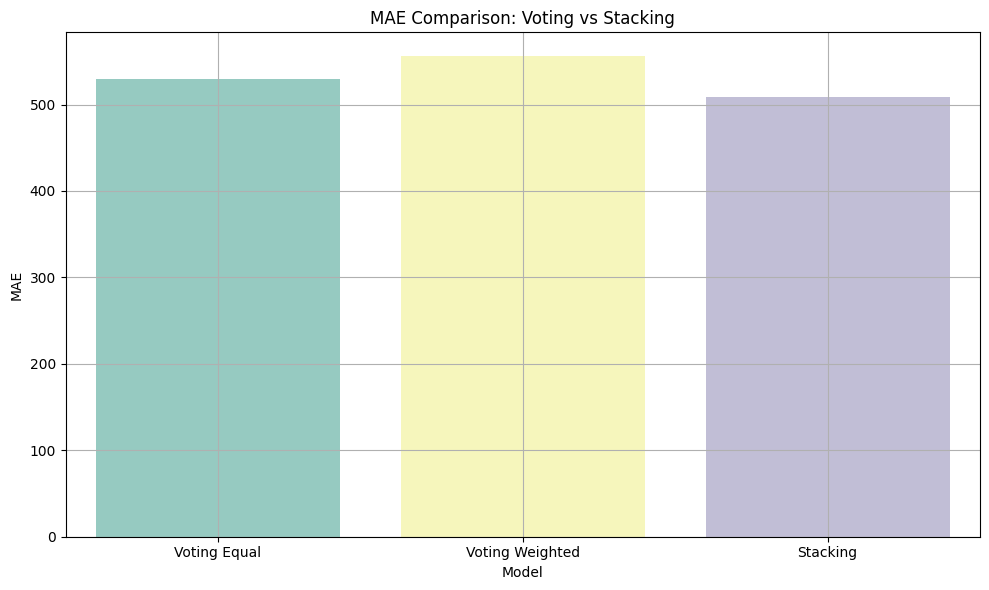

In [6]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Model", y="RMSE", palette="Set2")
plt.title("RMSE Comparison: Voting vs Stacking")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Model", y="MAE", palette="Set3")
plt.title("MAE Comparison: Voting vs Stacking")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()